# Volumetric Surface Reconstruction

Explain process and approach

### Dependencies

In [170]:
%matplotlib notebook

import numpy as np
import maxflow
import matplotlib.pyplot as plt
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D

## Load Data

Describe the data and what it is 

In [171]:
class Data:
    def __init__(self, data_set):
        self.data_set = data_set
        self.init_bounding_box()
        self.load_camera_info()
        
    def init_bounding_box(self):
        bounding_boxes = {
            'dinoSR': {
                'x': np.array([-0.07, 0.02]),
                'y': np.array([-0.02, 0.07]),
                'z': np.array([-0.07, 0.02])
            },
            'dinoR': {
                'x': np.array([-0.03, 0.06]),
                'y': np.array([-0.022, 0.11]),
                'z': np.array([-0.02, 0.06])
            },
            'templeSR': {
                'x': np.array([-0.08, 0.03]),
                'y': np.array([0.0, 0.18]),
                'z': np.array([-0.02, 0.06])
            }
        }
        self.bounding_box = bounding_boxes[self.data_set]
        
    def load_camera_info(self):
        
        # Dictionary of data_sets with image_paths
        image_paths = {
            'dinoSR': 'dinoSparseRing/',
            'dinoR': 'dinoRing/',
            'templeSR': 'templeSparseRing/'
        }
        
        # Open file in read mode
        path = image_paths[self.data_set]
        fp = open(path+self.data_set+'_par.txt', 'r')  

        num_images = int(fp.readline())
        
        P = []           # projection matrices
        T = []           # camera positions
        imgs = []        # images
        
        for i in xrange(num_images):
            raw_info = fp.readline().split()
            img_name = raw_info[0]
            raw_info = map(float, raw_info[1:])

            # Projection Matrix of the camera
            K = np.array(raw_info[0:9]).reshape(3,3)
            R = np.array(raw_info[9:18]).reshape(3,3)
            t = np.array(raw_info[18:])
            Rt = np.stack((R[:,0], R[:,1], R[:,2], t), axis=1)
            P.append(np.matmul(K, Rt))
            
            # Position of camera is Translation vector
            T.append(-1.0*np.matmul(np.linalg.inv(R), t))

            # Read Image and store
            img = plt.imread(path+img_name)
            imgs.append(img)
        
        self.P = np.array(P)
        self.T = np.array(T)
        self.imgs = np.array(imgs)
            
    def init_silhouttes(self, Segment):
        sils = []        # silhouettes
        
        for img in self.imgs:
            # create silhouttes using segmentation method
            sil = Segment(img).run()
            sils.append(sil)
        
        self.sils = np.array(sils)
    

### Display Data

Image shape:  (480, 640, 3)


<IPython.core.display.Javascript object>


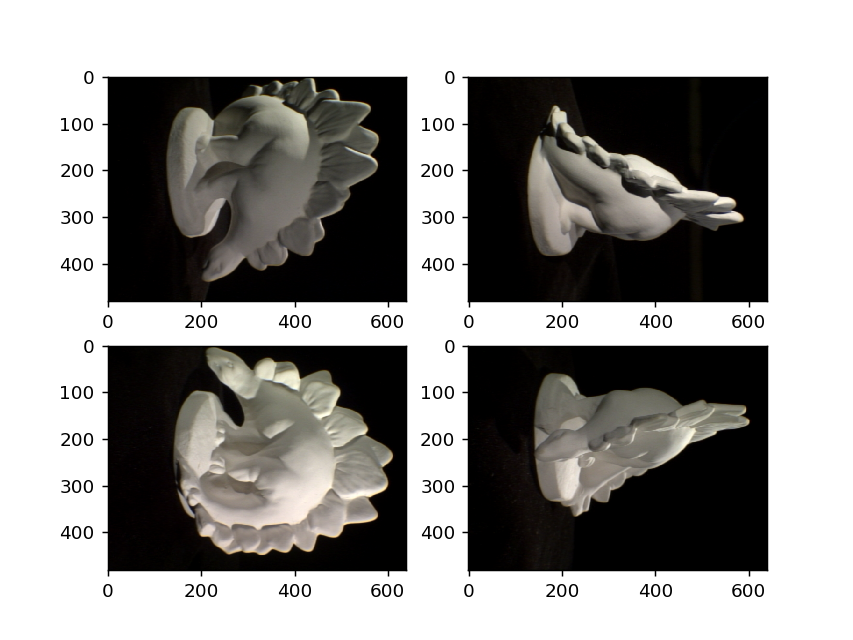

In [172]:
data = Data('dinoSR')

print "Image shape: ", data.imgs[0].shape

num_images = data.imgs.shape[0]
plt.figure()
plt.subplot(2,2,1)
plt.imshow(data.imgs[0*num_images/4])
plt.show()
plt.subplot(2,2,2)
plt.imshow(data.imgs[1*num_images/4])
plt.show()
plt.subplot(2,2,3)
plt.imshow(data.imgs[2*num_images/4])
plt.show()
plt.subplot(2,2,4)
plt.imshow(data.imgs[3*num_images/4])
plt.show()
    

## Segmentation

Explain what is done to segment the images. Explain what can be done

### Threshold Segmentation

In [173]:
class ThresholdSegment:
    def __init__(self, image, threshold=0.1):
        self.image = image
        self.threshold = threshold
    
    def run(self):
        sil = np.zeros((self.image.shape[0], self.image.shape[1]))
        sil[np.where(self.image > self.threshold)[:2]] = 1
        return sil


### Display Results

<IPython.core.display.Javascript object>


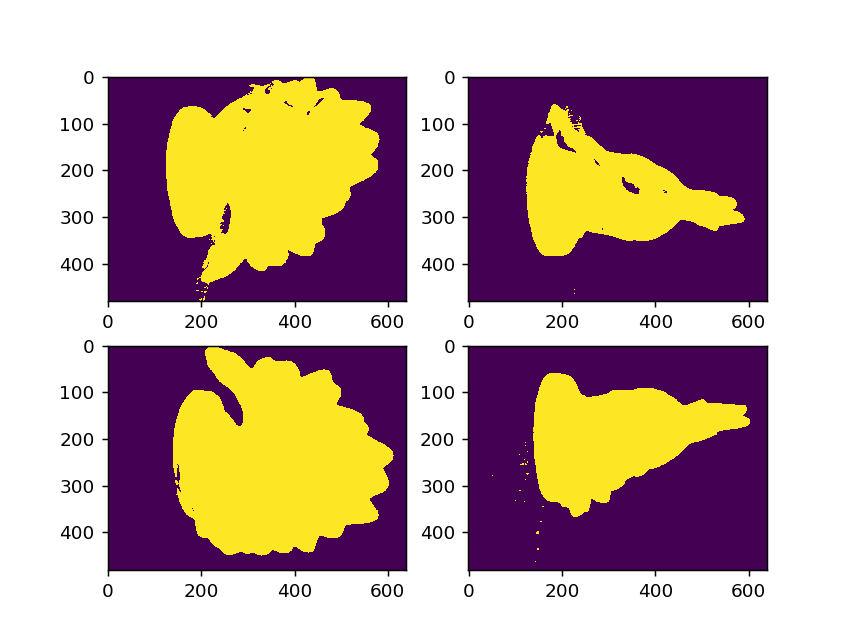

In [174]:
data.init_silhouttes(ThresholdSegment)

plt.figure()
plt.subplot(2,2,1)
plt.imshow(data.sils[0*num_images/4])
plt.show()
plt.subplot(2,2,2)
plt.imshow(data.sils[1*num_images/4])
plt.show()
plt.subplot(2,2,3)
plt.imshow(data.sils[2*num_images/4])
plt.show()
plt.subplot(2,2,4)
plt.imshow(data.sils[3*num_images/4])
plt.show()

### K-means Segmentation
### Graph-Cut Segmentation

## Visual Hull

Explain what Visual hull is and process behind the approach

In [175]:
class Voxel:
    def __init__(self, args):
        self.x = args[0]
        self.y = args[1]
        self.z = args[2]
        self.val = args[3]
    
    def log(self):
        print "\tx: ", self.x
        print "\ty: ", self.y
        print "\tz: ", self.z
        print "\tval: ", self.val
    
    def homo(self):
        return np.array([self.x, self.y, self.z, 1]).reshape(4, 1)

class VisualHull:
    def __init__(self, 
                 data, 
                 voxel_size=np.array([0.002, 0.002, 0.002])):
        
        self.data = data
        self.voxel_size = voxel_size

        self.sils = self.data.sils
        self.P = self.data.P
        
        self.img_height = self.data.imgs.shape[1]
        self.img_width = self.data.imgs.shape[2]
        
    def initialize_voxels(self, xlim, ylim, zlim):
        
        # Determine shape of visual hull grid
        hull_shape = np.zeros(3)
        hull_shape[0] = abs(xlim[1] - xlim[0])/self.voxel_size[0]
        hull_shape[1] = abs(ylim[1] - ylim[0])/self.voxel_size[1]
        hull_shape[2] = abs(zlim[1] - zlim[0])/self.voxel_size[2]
        self.hull_shape = hull_shape + np.ones(3)
        
        # Compute total voxels using grid shape
        self.total_voxels = np.prod(self.hull_shape)

        # List storing (x, y, z, val) of each voxel
        self.voxels2D_list = np.ones((int(self.total_voxels), 4), float)
        
        # Compute increment and decrement step direction
        sx = xlim[0]
        ex = xlim[1]
        sy = ylim[0]
        ey = ylim[1]
        sz = zlim[0]
        ez = zlim[1]

        if ex > sx:
            x_step = self.voxel_size[0]
        else:
            x_step = -self.voxel_size[0]

        if ey > sy:
            y_step = self.voxel_size[1]
        else:
            y_step = -self.voxel_size[1]

        if ez > sz:
            z_step = self.voxel_size[2]
        else:
            z_step = -self.voxel_size[2]
            
        self.x_step = x_step
        self.y_step = y_step
        self.z_step = z_step
        
        x_linspace = np.linspace(sx, ex, int(self.hull_shape[0]))
        y_linspace = np.linspace(sy, ey, int(self.hull_shape[1]))
        z_linspace = np.linspace(sz, ez, int(self.hull_shape[2]))
        
        # Initialize voxel list
        l = 0;
        for z in z_linspace:
            for x in x_linspace:
                for y in y_linspace:
                    self.voxels2D_list[l, 0:3] = np.array([x, y, z])
                    l = l+1
                    
    def create_visual_hull(self):
        
        # Homogeneous 3D world coordinates 
        object_points3D_homo = np.transpose(self.voxels2D_list)
        
        # Iterate through each camera position 
        print "Processing frames: ",
        for i in xrange(self.P.shape[0]):
            print i+1, " ",
            
            # Homogeneous image coordinate for camera/image i
            points2D_homo = np.matmul(self.P[i], object_points3D_homo)
            
            # Remove infinity points
            inf_ind = np.where(points2D_homo[2] == 0)
            points2D_homo[:, inf_ind] = 1
            
            # Image coordinates
            points2D = np.divide(points2D_homo[0:2], [points2D_homo[2], points2D_homo[2]]);

            # Remove points outside image boundary
            ind_x_lt_0 = np.where(points2D[0] < 0)
            ind_y_lt_0 = np.where(points2D[1] < 0)
            ind_x_gt_w = np.where(points2D[0] >= self.img_width)
            ind_y_gt_h = np.where(points2D[1] >= self.img_height)
            points2D[:, ind_x_lt_0] = 1
            points2D[:, ind_y_lt_0] = 1
            points2D[:, ind_x_gt_w] = 1
            points2D[:, ind_y_gt_h] = 1
            
            # Make voxel value 0 for those not being projected
            ind = np.ravel_multi_index(
                (points2D[1,:].astype(int), points2D[0,:].astype(int)), 
                dims=(self.img_height, self.img_width), order='C')
            cur_sil = self.data.sils[i]
            img_val = cur_sil.ravel()[ind]
            zero_ind = np.where(img_val == 0)[0]
            
            # Update list of voxels
            self.voxels2D_list[zero_ind, 3] = 0
            
    def create_grids(self):
        # Initialize Grids - one with all voxel info, one just with voxel values
        self.voxel3D = np.zeros([int(self.hull_shape[1]), int(self.hull_shape[0]), int(self.hull_shape[2])], dtype=float)
        self.visual_hull = np.zeros([int(self.hull_shape[1]), int(self.hull_shape[0]), int(self.hull_shape[2])], dtype=object)

        # Assign values in 3D grid
        l=0
        for zi in xrange(self.voxel3D.shape[2]):
            for xi in xrange(self.voxel3D.shape[1]):
                for yi in xrange(self.voxel3D.shape[0]):
                    self.voxel3D[yi, xi, zi] = self.voxels2D_list[l, 3]
                    self.visual_hull[yi, xi, zi] = Voxel(self.voxels2D_list[l,:])
                    l = l+1
                    
    def plot_marching_cube(self):
        # Display resulting triangular mesh using Matplotlib.
        verts, faces, normals, values = measure.marching_cubes_lewiner(self.voxel3D.T, 0)

        fig = plt.figure()
        ax = fig.gca(projection='3d')

        # Fancy indexing: `verts[faces]` to generate a collection of triangles
        mesh = Poly3DCollection(verts[faces])
        mesh.set_edgecolor('k')
        mesh.set_facecolor('r')
        ax.add_collection3d(mesh)

        ax.set_xlabel("x-axis")
        ax.set_ylabel("y-axis")
        ax.set_zlabel("z-axis")

        ax.set_xlim(0, self.voxel3D.T.shape[0]) # a = 6 (times two for 2nd ellipsoid)
        ax.set_ylim(0, self.voxel3D.T.shape[1]) # b = 10
        ax.set_zlim(0, self.voxel3D.T.shape[2]) # c = 16

        plt.tight_layout()
        plt.show()

    def run(self):
        print "Initializing Voxels ->", 
        self.initialize_voxels(
            self.data.bounding_box['x'], 
            self.data.bounding_box['y'], 
            self.data.bounding_box['z'])
        print "Forming Visual Hull ->",
        self.create_visual_hull()
        print "-> Creating 3D grids ->",
        self.create_grids()
        print "Plotting marching cubes ... ",
        self.plot_marching_cube()


### Results

Initializing Voxels -> Forming Visual Hull -> Processing frames:  1   2   3   4   5   6   7   8   9   10   11   12   13   14   15   16   -> Creating 3D grids -> Plotting marching cubes ... 

<IPython.core.display.Javascript object>


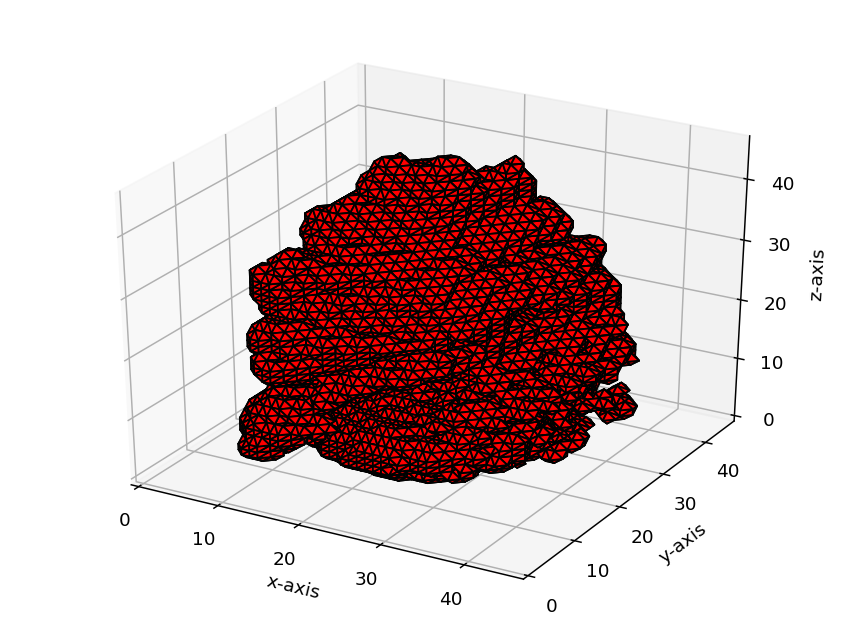

In [176]:
hull = VisualHull(data, np.array([0.002, 0.002, 0.002]))
hull.run()

# Volumetric Graph Cuts via Photoconsistency

Explain graph construction and reasoning behind why it will work

In [177]:
def breadth_first_search(grid, ind):
    
    q = []
    q.insert(0,(1,ind, None))
    x_lim, y_lim, z_lim = grid.shape
    seen = set()
    
    while q:
        cnt, current, prev = q.pop()
        if current in seen:
            continue
        
        x = current[0]
        y = current[1]
        z = current[2]
        
        
        if x < 0 || x > x_lim-1 || y < 0 || y > y_lim-1 || z < 0 || z > z_lim-1 || grid[x,y,z].val == 0:
            return cnt, prev
        
        seen.add(current)
        
        q.append((cnt+1,np.array([x+1,y,z]), current))
        q.append((cnt+1,np.array([x-1,y,z]), current))
        q.append((cnt+1,np.array([x,y+1,z]), current))
        q.append((cnt+1,np.array([x,y-1,z]), current))
        q.append((cnt+1,np.array([x,y,z+1]), current))
        q.append((cnt+1,np.array([x,y,z-1]), current))
            
    

SyntaxError: invalid syntax (<ipython-input-177-15e3da2c67ec>, line 18)

In [178]:
def _bresenhamline_nslope(slope):
    """
    Normalize slope for Bresenham's line algorithm.

    >>> s = np.array([[-2, -2, -2, 0]])
    >>> _bresenhamline_nslope(s)
    array([[-1., -1., -1.,  0.]])

    >>> s = np.array([[0, 0, 0, 0]])
    >>> _bresenhamline_nslope(s)
    array([[ 0.,  0.,  0.,  0.]])

    >>> s = np.array([[0, 0, 9, 0]])
    >>> _bresenhamline_nslope(s)
    array([[ 0.,  0.,  1.,  0.]])
    """
    scale = np.amax(np.abs(slope), axis=1).reshape(-1, 1)
    zeroslope = (scale == 0).all(1)
    scale[zeroslope] = np.ones(1)
    normalizedslope = np.array(slope, dtype=np.double) / scale
    normalizedslope[zeroslope] = np.zeros(slope[0].shape)
    return normalizedslope

def _bresenhamlines(start, end, max_iter):
    """
    Returns npts lines of length max_iter each. (npts x max_iter x dimension) 

    >>> s = np.array([[3, 1, 9, 0],[0, 0, 3, 0]])
    >>> _bresenhamlines(s, np.zeros(s.shape[1]), max_iter=-1)
    array([[[ 3,  1,  8,  0],
            [ 2,  1,  7,  0],
            [ 2,  1,  6,  0],
            [ 2,  1,  5,  0],
            [ 1,  0,  4,  0],
            [ 1,  0,  3,  0],
            [ 1,  0,  2,  0],
            [ 0,  0,  1,  0],
            [ 0,  0,  0,  0]],
    <BLANKLINE>
           [[ 0,  0,  2,  0],
            [ 0,  0,  1,  0],
            [ 0,  0,  0,  0],
            [ 0,  0, -1,  0],
            [ 0,  0, -2,  0],
            [ 0,  0, -3,  0],
            [ 0,  0, -4,  0],
            [ 0,  0, -5,  0],
            [ 0,  0, -6,  0]]])
    """
    if max_iter == -1:
        max_iter = np.amax(np.amax(np.abs(end - start), axis=1))
    npts, dim = start.shape
    nslope = _bresenhamline_nslope(end - start)

    # steps to iterate on
    stepseq = np.arange(1, max_iter + 1)
    stepmat = np.tile(stepseq, (dim, 1)).T

    # some hacks for broadcasting properly
    bline = start[:, np.newaxis, :] + nslope[:, np.newaxis, :] * stepmat

    # Approximate to nearest int
    return np.array(np.rint(bline), dtype=start.dtype)

def bresenhamline(start, end, max_iter=5):
    """
    Returns a list of points from (start, end] by ray tracing a line b/w the
    points.
    Parameters:
        start: An array of start points (number of points x dimension)
        end:   An end points (1 x dimension)
            or An array of end point corresponding to each start point
                (number of points x dimension)
        max_iter: Max points to traverse. if -1, maximum number of required
                  points are traversed

    Returns:
        linevox (n x dimension) A cumulative array of all points traversed by
        all the lines so far.

    >>> s = np.array([[3, 1, 9, 0],[0, 0, 3, 0]])
    >>> bresenhamline(s, np.zeros(s.shape[1]), max_iter=-1)
    array([[ 3,  1,  8,  0],
           [ 2,  1,  7,  0],
           [ 2,  1,  6,  0],
           [ 2,  1,  5,  0],
           [ 1,  0,  4,  0],
           [ 1,  0,  3,  0],
           [ 1,  0,  2,  0],
           [ 0,  0,  1,  0],
           [ 0,  0,  0,  0],
           [ 0,  0,  2,  0],
           [ 0,  0,  1,  0],
           [ 0,  0,  0,  0],
           [ 0,  0, -1,  0],
           [ 0,  0, -2,  0],
           [ 0,  0, -3,  0],
           [ 0,  0, -4,  0],
           [ 0,  0, -5,  0],
           [ 0,  0, -6,  0]])
    """
    # Return the points as a single array
    return _bresenhamlines(start, end, max_iter).reshape(-1, start.shape[-1])

def check_collsion(ind, cameras):
    
    # convert camera reak coordinates to their supposed grid coordinate
    origin = [xlim[0], ylim[0], zlim[0]]
    
    
    start = cameras
    
    end = ind
    
    bresenhamline(cameras, ind)


In [179]:
class VolumetricGraphCuts:
    
    def __init__(self, data, visual_hull, k=3, _lambda=100):
        
        # Initialize Visual Hull
        self.hull = visual_hull.visual_hull
        self.init_hull_surf()
        self.voxel_size = visual_hull.voxel_size
        self.voxel_list = visual_hull.voxels2D_list
        
        # Initialize Camera/Image data
        self.data = data
        self.T = self.data.T
        self.P = self.data.P
        self.imgs = self.data.imgs
        
        self.img_height = self.data.imgs.shape[1]
        self.img_width = self.data.imgs.shape[2]
        
        
        # Initialize Hyper parameters
        self.k = k
        self._lambda = _lambda
        
        print "Initializing Graph ..."
        self.init_graph(debug=True)
        print "done"
        
    def init_hull_surf(self):
        # Visual hull with only surface values
        self.hull_surf = np.zeros(self.hull.shape, float)
        for y in xrange(self.hull.shape[0]):
            for x in xrange(self.hull.shape[1]):
                for z in xrange(self.hull.shape[2]):
                    if self.hull[y,x,z].val == 1:
                        self.hull_surf[y,x,z] = 1
                        if x > 0 and x < self.hull.shape[1]-1 and (self.hull[y, x-1, z].val == 0 or self.hull[y, x+1, z].val == 0):
                            self.hull_surf[y,x,z] = 2
                        if y > 0 and y < self.hull.shape[0]-1 and (self.hull[y-1, x, z].val == 0 or self.hull[y+1, x, z].val == 0):
                            self.hull_surf[y,x,z] = 2
                        if z > 0 and z < self.hull.shape[2]-1 and (self.hull[y, x, z-1].val == 0 or self.hull[y, x, z+1].val == 0):
                            self.hull_surf[y,x,z] = 2

    def init_graph(self, debug=False):
        # Initialize Graph
        if debug:
            print "\tGraph ->",
        self.graph = maxflow.GraphFloat()
        if debug:
            print "created"
        
        if debug:
            print "\tNodes ->",
            
        self.node_ids = self.graph.add_grid_nodes(self.hull_surf.shape)
        if debug:
            print "added"
        
        if debug:
            print "\tT-links ->",
        self.add_sink_edges() 
        if debug:
            print "sink done ->",
        self.add_source_edges()
        if debug:
            print "source done"
            
        if debug:
            print "\tN-links ->",
        self.add_n_links()
        if debug:
            print "done"
        
    def add_sink_edges(self):
#         def _ind(x, y, z):
#             return z*self.hull.shape[2] + x*self.hull.shape[1] + y*self.hull.shape[0]
        
#         for z in xrange(self.hull.shape[2]):
#             for x in xrange(self.hull.shape[1]):
#                 for y in xrange(self.hull.shape[0]):
#                     if self.hull[y,x,z].val == 0 or self.hull[y,x,z].val == 2:
#                         self.graph.add_tedge(_ind(x,y,z), 0, float('inf'))

        surf_ids = self.node_ids[np.where(self.hull_surf == 2)]
        for ind in surf_ids:
            self.graph.add_tedge(ind, 0, float('inf'))
    
    def add_source_edges(self):
#         non_surf_inds = np.where(self.hull_surf == 1)
#         non_surf_inds = non_surf_inds[2]*self.hull_surf.shape[2] + non_surf_inds[1]*self.hull_surf.shape[1] + non_surf_inds[0]*self.hull_surf.shape[0]
    
#         # Add t-link of weight lambda * h^3 to all nodes that are not on surface
#         Wb = self._lambda * np.prod(self.voxel_size)
#         for ind in non_surf_inds:
#             self.graph.add_tedge(ind, Wb, 0)

        non_surf_ids = self.node_ids[np.where(self.hull_surf == 1)]
        Wb = self._lambda * np.prod(self.voxel_size)
        for ind in non_surf_ids:
            self.graph.add_tedge(ind, Wb, 0)
            
    def photo_consistency(self, world_coord):
        # Assume this is correct
        d = []
        for t in self.T:
            d.append(np.linalg.norm(world_coord[:3]-t))
        inds = np.argsort(d)[:self.k]
        
        intensities = []
        for i in inds:
            img_coord = np.matmul(self.P[i], world_coord)
            
            # Skip is infinity point
            if img_coord[2] == 0:
                continue

            # Image coordinates
            img_coord = np.divide(img_coord[0:2], [img_coord[2], img_coord[2]]);

            # Remove points outside image boundary
            if (img_coord[0] < 0 or img_coord[0] >= self.img_width):
                continue
            if (img_coord[1] < 0 or img_coord[1] >= self.img_height):
                continue
            
            intensities.append(self.imgs[i, int(img_coord[1]), int(img_coord[0])])
                
        
        intensities = np.array(intensities)
        avg_I = np.mean(intensities, axis=0)
        
        pc = 0
        for I in intensities:
            pc += np.linalg.norm(I - avg_I)**2
        
        return pc
            
            
#     def add_n_links(self, debug=False):
        
#         y_step = self.voxel_size[1]/2
#         z_step = self.voxel_size[2]/2
        
#         def left(x, y, z):
#             return x!=0 and self.hull[y, x-1, z].val == 1
        
#         def left_edge_coord(x,y,z):
#             return self.hull[y,x,z].homo() - np.array([self.voxel_size[0]/2, 0, 0, 0]).reshape(4, 1)
            
#         def up(x, y, z):
#             return y!=0 and self.hull[y-1, x, z].val == 1
        
#         def up_edge_coord(x,y,z):
#             return self.hull[y,x,z].homo() - np.array([0, self.voxel_size[1]/2, 0, 0]).reshape(4, 1)
        
#         def front(x, y, z):
#             return z!=0 and self.hull[y, x, z-1].val == 1
        
#         def front_edge_coord(x,y,z):
#             return self.hull[y,x,z].homo() - np.array([0, 0, self.voxel_size[2]/2, 0]).reshape(4, 1)
        
#         inds = np.where(self.hull_surf > 0)
        
#         def _ind(x, y, z):
#             return z*self.hull.shape[2] + x*self.hull.shape[1] + y*self.hull.shape[0]

#         for j in xrange(inds[0].shape[0]):
#             x = inds[1][j]
#             y = inds[0][j]
#             z = inds[2][j]
#             if left(x,y,z):
#                 Wl = self.photo_consistency(left_edge_coord(x,y,z))
#                 self.graph.add_edge(_ind(x,y,z), _ind(x-1,y,z), Wl, Wl)
#             if up(x,y,z):
#                 Wu = self.photo_consistency(up_edge_coord(x,y,z))
#                 self.graph.add_edge(_ind(x,y,z), _ind(x,y-1,z), Wu, Wu)
#             if front(x,y,z):
#                 Wf = self.photo_consistency(front_edge_coord(x,y,z))
#                 self.graph.add_edge(_ind(x,y,z), _ind(x,y,z-1), Wf, Wf)

    def add_n_links(self, debug=False):
        
        
#         def left(x, y, z):
#             return x!=0 and self.hull[y, x-1, z].val == 1
        
#         def left_edge_coord(x,y,z):
#             return self.hull[y,x,z].homo() - np.array([self.voxel_size[0]/2, 0, 0, 0]).reshape(4, 1)
            
#         def up(x, y, z):
#             return y!=0 and self.hull[y-1, x, z].val == 1
        
#         def up_edge_coord(x,y,z):
#             return self.hull[y,x,z].homo() - np.array([0, self.voxel_size[1]/2, 0, 0]).reshape(4, 1)
        
#         def front(x, y, z):
#             return z!=0 and self.hull[y, x, z-1].val == 1
        
#         def front_edge_coord(x,y,z):
#             return self.hull[y,x,z].homo() - np.array([0, 0, self.voxel_size[2]/2, 0]).reshape(4, 1)
        

        
        inds = np.where(self.hull_surf > 0)
        ids = self.node_ids[inds]

        mult = (4*np.pi*self.voxel_size[0]*self.voxel_size[0])/3.0
        
        for i in range(len(inds[0])):
            x = inds[0][i]
            y = inds[1][i]
            z = inds[2][i]
            vox = self.hull[x,y,z]
            ind = ids[i]
            
            if x != 0 and self.hull[x-1, y, z].val > 0:
#                 print 'HERE'
                vox_l = self.hull[x-1, y, z]
                ind_l = self.node_ids[x-1,y,z]
                lft_edg_cord = (vox.homo() + vox_l.homo())/2.0
                Wl = mult*self.photo_consistency(lft_edg_cord)
                self.graph.add_edge(ind, ind_l, Wl, Wl)
                #if i % 100 == 0:
#                 print "l = {}".format(Wl)
    
            if y != 0 and self.hull[x, y-1, z].val > 0:
                vox_u = self.hull[x, y-1, z]
                ind_u = self.node_ids[x, y-1, z]
                up_edg_cord = (vox.homo() + vox_u.homo())/2.0
                Wu = mult*self.photo_consistency(up_edg_cord)
                self.graph.add_edge(ind, ind_u, Wu, Wu)
                #if i % 100 == 0:
#                 print "u = {}".format(Wu)

            if z != 0 and self.hull[x, y, z-1].val > 0:
                vox_f = self.hull[x, y, z-1]
                ind_f = self.node_ids[x, y, z-1]
                fnt_edg_cord = (vox.homo() + vox_f.homo())/2.0
                Wf = mult*self.photo_consistency(fnt_edg_cord)
                self.graph.add_edge(ind, ind_f, Wf, Wf)
                #if i % 100 == 0:
#                 print "f = {}".format(Wf)
                
            
    
    def create3D_structure(self):
        def _ind(x, y, z):
            return z*self.hull.shape[2] + x*self.hull.shape[1] + y*self.hull.shape[0]
        
        count=0
        self.structure3D = np.zeros(self.hull.shape, float)
        for z in xrange(self.hull.shape[2]):
            for x in xrange(self.hull.shape[1]):
                for y in xrange(self.hull.shape[0]):
                    if self.hull[y,x,z].val == 0:
                        self.structure3D[y,x,z] = 0
                    else:
                        node_id = _ind(x, y, z)
                        self.structure3D[y,x,z] = self.graph.get_segment(node_id)
                        if self.graph.get_segment(node_id) == 0:
                            count += 1
        print "Removed Voxels from visual hull: ", count
    
    def plot3D_structure(self):
        # Display resulting triangular mesh using Matplotlib.
        verts, faces, normals, values = measure.marching_cubes_lewiner(self.structure3D.T, 0)

        fig = plt.figure()
        ax = fig.gca(projection='3d')

        # Fancy indexing: `verts[faces]` to generate a collection of triangles
        mesh = Poly3DCollection(verts[faces])
        mesh.set_edgecolor('k')
        ax.add_collection3d(mesh)

        ax.set_xlabel("x-axis")
        ax.set_ylabel("y-axis")
        ax.set_zlabel("z-axis")

        ax.set_xlim(0, self.structure3D.T.shape[0]) # a = 6 (times two for 2nd ellipsoid)
        ax.set_ylim(0, self.structure3D.T.shape[1]) # b = 10
        ax.set_zlim(0, self.structure3D.T.shape[2]) # c = 16

        plt.tight_layout()
        plt.show()
    
    def run(self):
        print "Running MaxFlow ->",
        self.graph.maxflow()
        print "done"
        
        print "Create 3D Structure from graph ->",
        segments = self.graph.get_grid_segments(self.node_ids)
        
        self.create3D_structure()
        print "done"
        
        print "Plot final result ->",
        self.plot3D_structure()
        print "done"

In [180]:
VGC.hull_surf.shape

(67, 46, 41)

### Results

In [162]:
VGC = VolumetricGraphCuts(data, hull)

Initializing Graph ...
	Graph -> created
	Nodes -> added
	T-links -> sink done -> source done
	N-links -> done
done


In [163]:
VGC.run()

Running MaxFlow -> done
Create 3D Structure from graph -> Removed Voxels from visual hull:  11831
done
Plot final result ->

RuntimeError: No surface found at the given iso value.

In [155]:
def plot_marching_cube(vox):
    # Display resulting triangular mesh using Matplotlib.
    verts, faces, normals, values = measure.marching_cubes_lewiner(vox.T,0)

    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces])
    mesh.set_edgecolor('k')
    mesh.set_facecolor('r')
    ax.add_collection3d(mesh)

    ax.set_xlabel("x-axis")
    ax.set_ylabel("y-axis")
    ax.set_zlabel("z-axis")

    ax.set_xlim(0, vox.T.shape[0]) # a = 6 (times two for 2nd ellipsoid)
    ax.set_ylim(0, vox.T.shape[1]) # b = 10
    ax.set_zlim(0, vox.T.shape[2]) # c = 16

    plt.tight_layout()
    plt.show()

In [164]:
VGC.graph.maxflow()
segments = VGC.graph.get_grid_segments(VGC.node_ids)

In [165]:
np.where(segments==True)[0].shape

(9794,)

In [166]:
np.where(VGC.hull_surf>0)[0].shape

(11831,)

<IPython.core.display.Javascript object>


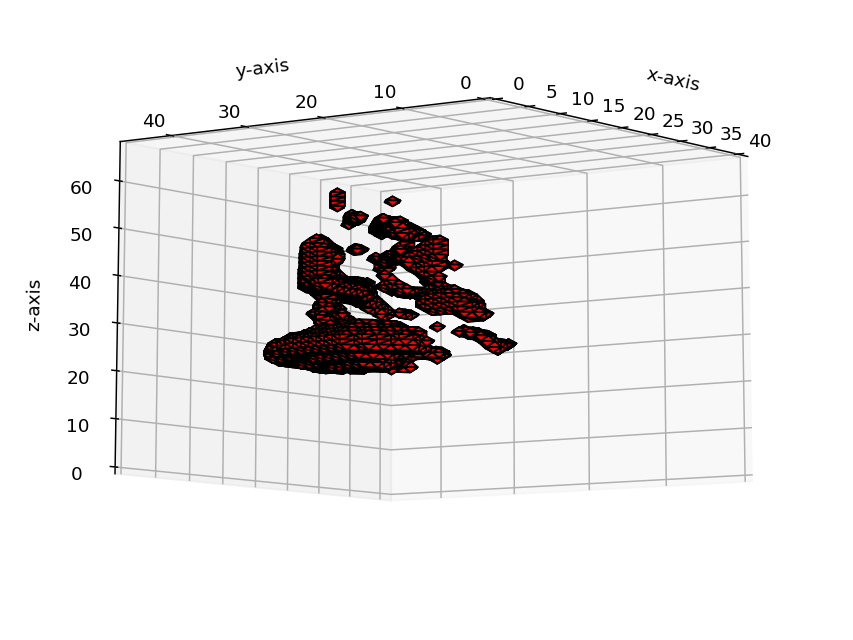

In [169]:
seg_num = np.zeros(segments.shape)

# seg_num[np.where(VGC.hull_surf==0)] = 0

# seg_num[np.where(segments==True)] = 0
seg_num[np.where(segments==False)] = 1
seg_num[np.where(VGC.hull_surf==0)] = 0

# seg_num[np.where(segments==True)] = 0
plot_marching_cube(seg_num)

<IPython.core.display.Javascript object>


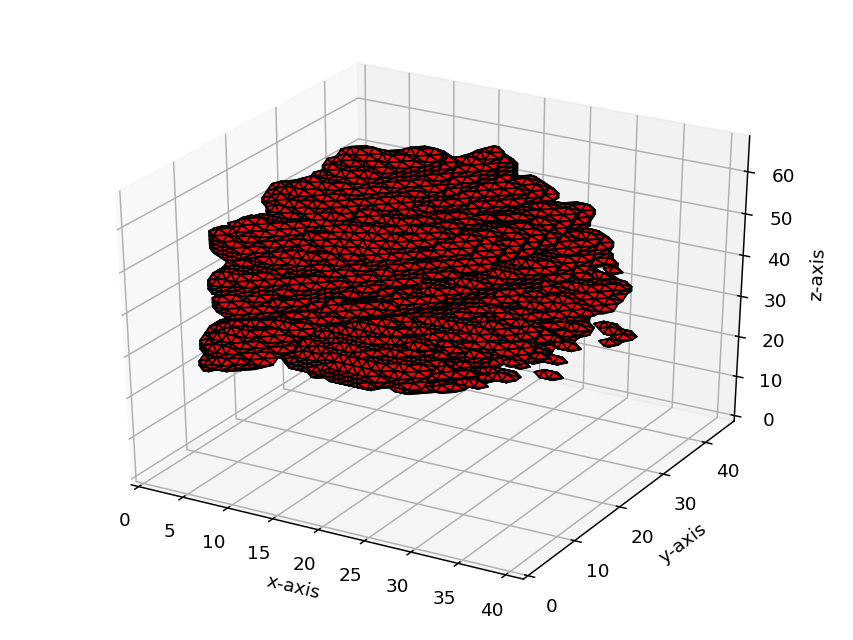

In [168]:
plot_marching_cube(VGC.hull_surf)

In [92]:
a = seg_num[np.where(VGC.hull_surf==2)]

In [43]:
len(list(np.where(VGC.hull_surf > 0)[0]))

13771

In [51]:
len(np.where(VGC.hull_surf > 0)[0])

13771

In [94]:
np.sum(a)/len(a)

1.0

In [100]:
a = (VGC.hull_surf[np.where(VGC.hull_surf>0)])#[np.where(segments==False)]

In [101]:
a

array([2., 2., 2., ..., 2., 2., 2.])